# DECSKS-18: 1D1V two species Vlasov-Poisson boundary problems

## Objectives

In this notebook we take steps to add functionality to DECSKS to handle non-periodic boundary conditions. In particular, we make steps to set up Dirichlet problems in the $x$ direction, while in $v_x$ we keep periodic boundaries. This permits problems as described in <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-15%20--%20Collisionless_sheath_problem/DECSKS-15%20--%20Collisionless_sheath_problem.ipynb">DECSKS-15: Collisionless sheath problems</a> to be accessed.

A to-do list includes:

<ul>
<li> Include a Dirichlet finite difference Poisson solver for electric potential $\phi$ calculation (cf. <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver/DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver.ipynb">DECSKS-04</a>); already coded and benchmarked.
<li> <u>Extension</u>: the routine <code>lib.convect.finalize_density</code> must be modified to handle mixed boundary conditions so that the correct sized density container is returned after each runthrough of <code>lib.convect.scheme</code>. This step can either be done generally, or we may suffice to just code the routine in this version to expect Dirichlet boundaries in $x$, and periodic boundaries in $v_x$.
<li> <u>Addition</u>: a routine <code>lib.boundaryconditions.nonperiodic</code> will be added to the package <code>lib.boundaryconditions</code> for orchestrating the passing of objects and handling of nonperiodic conditions (must handle both boundaries, whereas in periodic we only require ensuring all postpoints remain inside the grid). This is the natural first step in extending the code. The corresponding boundary conditions on the densities are that the walls are perfect absorbers, while the boundaries ion the potential are biasing voltages we choose and enforce.
<li> <u>Extension</u> (to be completed after the above are settled): a subroutine <code>lib.boundarycondtions.Dirichlet.chargedwall</code> will be included so that the value of the potential on the walls is determined by the charge density reaching the wall (i.e. self-consistent boundary condition).

</ul>

We step through the objects in an order that makes sense:

## Objective 1: Dirichlet Poisson (FD) solver

First we define two distinct pathways we can take based on function handle

In [ ]:
def compute_electric_field_fd_dirichlet(fe, fi, x, vx, n, sim_params):

    phi = Poisson_DBC_1D1V_2S(fe, fi, x, vx, n, sim_params)

    # currently the finite difference weight matrix W_dn1 is a 6th order LTE to
    # match the 6th order LTE on the Poisson solve
    dphi = 1 / x.width ** 1 * sim_params['W_dn1_LTE6'].dot(phi)
    Ex = -dphi

    return Ex

def compute_electric_field_fd_periodic(fe, fi, x, vx, n, sim_params):

    phi = Poisson_PBC_1D1V_2S(fe, fi, x, vx, n, sim_params)

    # currently the finite difference weight matrix W_dn1 is a 6th order LTE to
    # match the 6th order LTE on the Poisson solve
    dphi = 1 / x.width ** 1 * sim_params['W_dn1_LTE6'].dot(phi)
    Ex = -dphi

    return Ex

Which are called by in <code>lib.read</code> as

In [ ]:
# lib.read excerpt

    compute_electric_field_function_handle_prefix = "DECSKS.lib.fieldsolvers.compute_electric_field_"

    if BC['x']['upper'] == 'periodic' and BC['x']['lower'] == 'periodic':
        compute_electric_field_function_handle = "".join((compute_electric_field_function_handle_prefix, HOC['x'].lower()))
        compute_electric_field_function_handle = "".join((compute_electric_field_function_handle, '_periodic'))
    else:
        compute_electric_field_function_handle = "".join((compute_electric_field_function_handle_prefix, HOC['x'].lower()))
        compute_electric_field_function_handle = "".join((compute_electric_field_function_handle, '_dirichlet'))


So we have renamed 

    lib.fieldsolvers.compute_electric_field_fourier --> lib.fieldsolvers.compute_electric_field_fourier_periodic
    
to be consistent with the function call in lib.split

In [ ]:
# lib.split excerpt

                Ex = eval(sim_params['compute_electric_field_function_handle'])(fe, fi, x, vx, n, sim_params)

For Dirichlet boundaries, we establish the new method with the signature DBC (Dirichlet boundary conditions) which is largely the same as the periodic case, but has important differences.

In [ ]:
def Poisson_DBC_1D1V_2S(fe, fi,
                x, vx, n,
                sim_params):
    """6th order LTE finite difference Poisson solver for Dirichlet BCs

    see notebook DECSKS-04 for details on construction

    https://github.com/dsirajud/IPython-notebooks/blob/master/
    DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver/
    DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver.ipynb

    The signature 2S = "two species"

    inputs:
    fe -- (ndarray, dim=2) electron density fe(x,v,n) at time step t^n
                          used to compute ne(x,n) at time step t^n
    fi -- (ndarray, dim=2) ion density fe(x,v,n) at time step t^n
                          used to compute ni(x,n) at time step t^n
    x -- (instance) spatial variable
    v -- (instance) velocity variable
    n -- (int) time step number, t^n


    outputs:
    phi -- (ndarray,dim=2) scalar potential, phi(x,v) = phi(x) at time t^n,
           for i = 0, 1, ... , x.N - 1, one full period
    """
    fe = DECSKS.lib.domain.extract_active_grid(fe[n,:,:], x, sim_params)
    fi = DECSKS.lib.domain.extract_active_grid(fi[n,:,:], x, sim_params)

    # Poisson eq. has -(charge density) = ne - ni
    n_total = single_integration(fe - fi, of = x, wrt = vx)

    # form the tensor objects involved in the numerical solution
    #
    #     d^2 phi = n --> D*phi = b
    #
    # where     b = x.width ** 2 * B*n + phi_BC

    # boundary conditions: dirichlet

    phi_DBC = np.zeros(x.N)
    phi_DBC[0] = sim_params['BC']['x']['phi']['lower']
    phi_DBC[-1] = sim_params['BC']['x']['phi']['upper']

    b = x.width ** 2 * sim_params['Poisson_6th_order_FD_solver_matrices']['B'].dot(n_total) + phi_DBC

    # solve D*phi = b
    phi = LA.solve(sim_params['Poisson_6th_order_FD_solver_matrices']['D'], b)

    # generate the 2D map for every [i,j], note that each row is constant
    phi = np.outer(phi, np.ones([1,vx.N]))

    return phi

We have also removed the label PBC from the dictionary <code>sim_params['Poisson_6th_order_PBC_FD_solver_matrices'] --> sim_params['Poisson_6th_order_FD_solver_matrices']</code>, and thus store which matricesare needed in this common dictionary (see <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver/DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver.ipynb">DECSKS-18</a>. The relevant matrices are still constructed before the simulation in <code>lib.read</code>:

In [ ]:
# lib.read excerpt

def assemble_Poisson_6th_order_FD_solver_matrices(Nx, BC):

    Poisson_6th_order_FD_solver_matrices = {}

    # Nx is the number of active nodes in configuration
    if ( (BC['x']['lower'] == 'periodic') and (BC['x']['upper'] == 'periodic') ):
        # periodic boundaries
        Nx -= 1

        # Assemble FD matrix B
        B = np.zeros([Nx, Nx])
        for i in range(Nx):
            if i == 0:             # first row
                B[i,-2] = -1/240.
                B[i,-1] = 1/10.
                B[i,i] = 97/120.
                B[i,i+1] = 1/10.
                B[i,i+2] = -1/240.

            elif i == 1:           # second row
                B[i,-1] = -1/240.
                B[i,i-1] = 1/10.
                B[i,i] = 97/120.
                B[i,i+1] = 1/10.
                B[i,i+2] = -1/240.

            elif 1 < i < (Nx - 2): # 2 <= row <= third before last
                B[i,i-2] = -1/240.
                B[i,i-1] = 1/10.
                B[i,i] = 97/120.
                B[i,i+1] = 1/10.
                B[i,i+2] = -1/240.

            elif i == (Nx - 2): # second before last row
                B[i,i-2] = -1/240.
                B[i,i-1] = 1/10.
                B[i,i] = 97/120.
                B[i,i+1] = 1/10.
                B[i,0] = -1/240.

            elif i == (Nx - 1): # last row
                B[i,i-2] = -1/240.
                B[i,i-1] = 1/10.
                B[i,i] = 97/120.
                B[i,0] = 1/10.
                B[i,1] = -1/240.

    else: # dirichlet boundaries

        # Assemble FD matrix B
        B = np.zeros([Nx, Nx])
        for i in range(Nx):

            # redundant, included for transparency
            if i == 0 or i == Nx - 1:
                B[i,i] = 0

            elif i == 1:
                B[i,i-1] = 3/40.
                B[i,i] = 209/240.
                B[i,i+1] = 1/60.
                B[i,i+2] = 7/120.
                B[i,i+3] = -1/40.
                B[i,i+4] = 1/240.

            elif i == Nx-1:
                B[i,i] = 0

            elif 1 < i < Nx-2:
                B[i,i-2] = -1/240.
                B[i,i-1] = 1/10.
                B[i,i] = 97/120.
                B[i,i+1] = 1/10.
                B[i,i+2] = -1/240.

            elif i == Nx-2:
                B[i,i-4] = 1/240.
                B[i,i-3] = -1/40.
                B[i,i-2] = 7/120.
                B[i,i-1] = 1/60.
                B[i,i] = 209/240.
                B[i,i+1] = 3/40.

    D = np.zeros([Nx,Nx])
    for i in range(Nx):
        if i == 0:         # first row
            D[i,i] = -2
            D[i,i+1] = 1
            D[i,-1] = 1

        elif i == Nx - 1: # last row
            D[i,i] = -2
            D[i,i-1] = 1
            D[i,0] = 1
        else:              # interior rows
            D[i,i-1] = 1
            D[i,i] = -2
            D[i,i+1] = 1

    Poisson_6th_order_FD_solver_matrices['D'] = D
    Poisson_6th_order_FD_solver_matrices['B'] = B

    return Poisson_6th_order_FD_solver_matrices


The Dirichlet boundary conditions used in the solver:

In [ ]:
    phi_DBC = np.zeros(x.N)
    phi_DBC[0] = sim_params['BC']['x']['phi']['lower']
    phi_DBC[-1] = sim_params['BC']['x']['phi']['upper']

are read-in from <code>lib.read</code>

In [ ]:
# lib.read excerpt

    BC['x']['phi'] = {}
    BC['x']['phi']['lower'] = safe_eval(lines[131][lines[131].find('=')+1:].strip())
    BC['x']['phi']['upper'] = safe_eval(lines[132][lines[132].find('=')+1:].strip())

    BC['y']['phi'] = {}
    BC['y']['phi']['lower'] = safe_eval(lines[134][lines[134].find('=')+1:].strip())
    BC['y']['phi']['upper'] = safe_eval(lines[135][lines[135].find('=')+1:].strip())

    BC['z']['phi'] = {}
    BC['z']['phi']['lower'] = safe_eval(lines[137][lines[137].find('=')+1:].strip())
    BC['z']['phi']['upper'] = safe_eval(lines[138][lines[138].find('=')+1:].strip())


where

In [ ]:
    def safe_eval(s):
        try:
            return eval(s)
        except NameError:
            return s.lower()

the lines are from new entries in etc/params.dat


#### etc/params.dat excerpt

    --------------------------------------------------------------------------------
    Potential (phi) boundary conditions (currently only support periodic BCs on E)
    ================================================================================
    - 'lower' and 'upper' refer to domain boundaries on abscissas x, y, z
    -  if a variable is not simulated, must denote by 'None' (case sensitive)
    -  if value is to be computed self-consistently, denote by 'self-consistent'
    -  if value is determined per periodic boundary conditions, this section is ignored
    -  if value is fixed at a value, denote with numerical value
    
    lower boundary condition on x = -5
    upper boundary condition on x = 5
    
    lower boundary condition on y = None
    upper boundary condition on y = None
    
    lower boundary condition on z = None
    upper boundary condition on z = None


This completes the required changes for DBCs to be handled on the Poisson solve.

## Objective 2: Absorbing boundaries

We require removing any density packets that reach the boundary or beyond.

The update (remap) statement takes the form:

    f_new[k] = f_old +/- Uf
    
    f_new[k +/- 1] = +/- Uf
    
Hence, a direct way of ensuring any such prepoint that exits the domain in a time substep is not added to the total density an on-grid location to zero out <code>f_old</code> and <code>Uf</code> at such qualifying prepoints.

Note that the correctors <code>c</code> depend on the fractional CFL numbers only. The high order fluxes for each column $j$ are computed per

$$\underline{[Uf]}_{,j} = \underline{c}_{,j}\cdot\underline{\underline{d}}_{,,j}$$

Here, if $z$ is the variable being evolved with generalized velocity $v_z$ (recall, should $z$ be a physical velocity, we have transposed all relevant objects so that the variation occurs across columns, hence htis is general).

$$\underline{[Uf]}_{,j} = \underline{[Uf]}_{,j; N_z \times 1}, \qquad \underline{c}_{,j} = \underline{c}_{,j; N_z \times 1}, \qquad \underline{\underline{d}}_{,,j} = \underline{\underline{d}}_{,,j; N\times N_z \times 1}$$

where

$$\underline{c}_{,j} \sim \underline{\beta}_{,j} = \underline{\beta}_{,j}(\underline{\alpha}_{,j}) = \underline{\beta}_{,j}(v_{z,j}) \neq \underline{\beta}_{,j}[\underline{\underline{f}}]$$

but,

$$\underline{\underline{d}}_{,,j} \sim \underline{\partial_z f}_{,j}$$

The subtelty here is that the derivative terms <b>do</b> need to be calculated with all prepoints in place, as these pertain to the derivatives of the old density. Zeroing out the density entries that correspond to prepoints which exit the domain in the given time substep is just an obvious vehicle to achieve an absorbing boundary condition. Thus, we note that any zeroing of density or flux entries on <code>f_old</code> and <code>Uf</code> must be done after the derivatives are already computed. Conveniently, this is already the order of calculations done in DECSKS in the routine lib.convect.scheme. We make a generalization change to the boundary condition by toggling the function handle with an  <code>eval</code> function and increase the number of arguments that are unpacked, but little is changed overall. The changes include:

#### lib.convect.scheme

In [ ]:
def scheme(
    f_initial,
    n,
    sim_params,
    z,
    vz
    ):
    """Solves a collection of 1D advection (in z) equations by convected scheme
    and stacks the results in a 2D matrix

    inputs:
    f_initial -- (ndarray, ndim = 2) f[n-1,:,:] if first
             substep in a splitting algorithm or if none
             else, f[n,:,:]
    n -- (int) time step
    sim_params -- (dict) simulation parameters
    z -- (instance) phase space variable
    vz -- (instance) generalized velocity for z


    outputs:
    f_final -- (ndarray, ndim = 1 or 2) f[n,:] or f[n,:,:] updated
               after all steps have been completed
    """

    # (0) INITIALIZE FINAL DENSITY CONTAINER AND EXTRACT EVOLVED GRID
    f_final = np.zeros(f_initial.shape)
    f_initial = DECSKS.lib.domain.extract_active_grid(f_initial, z, sim_params)

    if z.str[0] == 'v':
        f_initial, z, vz = DECSKS.lib.domain.velocity_advection_prep(f_initial, z, vz)

    # (1) ADVECT DENSITY AND COMPUTE CORRESPONDING FLUXES
    z.postpointmesh = advection_step(z)

    # compute high order fluxes
    Uf = flux(
        sim_params,
        f_initial,
        z, vz        
        )


    f_initial, Uf, z = eval(sim_params['boundarycondition_function_handle'][z.str])(
        f_initial, Uf, z, sim_params)


    # (2) REMAP DENSITY TO GRID
    f_remapped = remap_step(
                       sim_params,
                       f_initial,
                       Uf,
                       n,
                       z,
                       vz
                       )

    # (3) COLLISION STEP (NOT YET IMPLEMENTED)
    # f_new = DECSKS.lib.collisions.collisiontype(f_old, z, n)

    # (4) RETURN FINAL DESTINY (density*)
    f_final = finalize_density(sim_params, f_remapped, f_final, z, vz)

    return f_final

The boundary condition (i.e. zeroing out exiting prepoints in <code>f_old</code> and <code>Uf</code> is done inside of <code>remap_step</code>). A dictionary has been added <code>sim_params['boundary_conditions_function_handle'][z.str]</code> which is formed in <code>lib.read</code> and aided by the new 'type' key/value pair stored in the dictionary <code>sim_params['BC']</code> which stores the string <code>'periodic'</code> or <code>'nonperiodic'</code> based on user input from the boundary condition in <code>etc/params.dat</code>

In [ ]:
# lib.read excerpt

    for var in ['x', 'y', 'z', 'vx', 'vy', 'vz']:
        if BC[var]['lower'] == 'periodic' and BC[var]['upper'] == 'periodic':
            BC[var]['type'] = 'periodic'
        elif BC[var]['lower'] == 'periodic' and BC[var]['upper'] != 'periodic':
            BC[var]['type'] = 'incompatible periodic BCs specified'
        elif BC[var]['lower'] != 'periodic' and BC[var]['upper'] == 'periodic':
            BC[var]['type'] = 'incompatible periodic BCs specified'
        else:
            BC[var]['type'] = 'nonperiodic'

    boundarycondition_function_handle_prefix = 'DECSKS.lib.boundaryconditions'

    # create a dictionary for every phase space variable simulated
    boundarycondition_function_handle = {}

    for var in phasespace_vars:
        boundarycondition_function_handle[var] = ".".join(
            (boundarycondition_function_handle_prefix, BC[var]['type']))
        
        .
        .
        .
        
   sim_params = dict(
    .
    .
    .
    
        BC = BC,    # boundary conditions on all phase space variables
        boundarycondition_function_handle = boundarycondition_function_handle,
    .
    .
    .
    )

    infile.close()

    return sim_params   

#### lib.boundaryconditions

In [ ]:
import numpy as np

def periodic(f_old, Uf, z, sim_params):
    """Applies periodic boundary conditions to
    postpoints

    inputs:
    f_old -- (ndarray, ndim=2) density array
    z -- (instance) phase space variable being evolved

    outputs:
    f_old -- (ndarray, ndim=2) Array with both periodic
             BCs being enforce
    z    -- (instance) phase sapce variable being evolved with
             updated attribute z.postpointmesh

    f_old, Uf returned for symmetry with nonperiodic routine below
    """
    z.postpointmesh = np.mod(z.postpointmesh, z.N)

    return f_old, Uf, z

def nonperiodic(f_old, Uf, z, sim_params):
    """orchestrates applying nonperiodic boundary conditions
    to the array w with total active grid points Nw. Nonperiodic
    boundary conditions require handling both left and right
    boundaries

    inputs:
    f_old -- (ndarray, ndim=2) density array
    z -- (instance) phase space variable being evolved

    outputs:
    f_old -- (ndarray, ndim=2) density with both left and right
             nonperiodic BCs enforced
    Uf -- (ndarray, ndim=2) high order fluxes with both left and right
             nonperiodic BCs enforced


    z returned (no changes) for symmetry with periodic routine above 
    """

    # lower boundary
    f_old, Uf = eval(sim_params['BC'][z.str]['type'] +
                           '_lower_boundary')(z, sim_params)

    # upper boundary
    f_old, Uf = eval(sim_params['BC'][z.str]['type'] +
                           '_upper_boundary')(z, sim_params)
    
    # since the relevant entries of f_old and Uf that exit the domain
    # are zeroed out, in order to have a clean addition as before
    # we map their postpoints to their corresponding periodic BC locations
    # so that there are no two shared postpoints by construction

    f_old, Uf, z = periodic(f_old, Uf, z, sim_params)

    # note that if there were shared postpoints (i.e set all such postpoint
    # indices whose prepoints indicate they leave the domain to the boundary indices)
    # the remap step would not allocate the correct densities since we use a matrix sum
    # rather than a (slow) loop (where we have an increment operator += at our disposal). 
    # In a matrix sum assignment, one cell's density would be allocated to the postpoint, 
    # the rest would be overwritten

    return f_old, Uf, z

def absorbing_lower_boundary(f_old, Uf, z):

    f_old = np.where(z.postpointmesh <= 0, 0, f_old)
    Uf = np.where(z.postpointmesh <= 0, 0, Uf)

    return f_old, Uf

def absorbing_upper_boundary(f_old, Uf, z):

    f_old = np.where(z.postpointmesh >= z.N, 0, f_old)
    Uf = np.where(z.postpointmesh >= z.N, 0, Uf)

    return f_old, Uf

There is a changeup that occurs here, <code>f_old</code> in this construction gets broadcasted to the dimensions of <code>z.postpointmesh</code> which has shape <code>(2, x.N, vx.N)</code>. This makes the object <code>f_old</code> incompatible with the rest of the code. We need to consider how to impelment the boundary conditions. Perhaps, we do just before each remap step with each "page" (0 or 1) of <code>z.postpointmesh</code>.

What remains is to consider the final function call in <code>lib.convect.scheme</code> above. The <code>lib.convect.finalize_density</code> was created for two reasons: (1) in the event of <code>vx</code> advection, many matrices have been transposed to be of the ordering <code>(vx.N, x.N)</code>, these need to be transposed again to restore the ordering to be the same as the density <code>f.shape = (x.Ngridpoints, vx.Ngridpoints)</code>, and (2) the shape <code>(x.N, vx.N)M</code> is not necessarily <code>(x.Ngridpoints, vx.Ngridpoints)</code>. In the current case, the active gridpoints <code>z.Ngridpoints = z.N + 1</code>) for example, and this function then fills in the final values at the endpoints by copying the opposite endpoint value.

For the current setup, we have it so that it assumes both boundaries are periodic:

#### <font color = "red">lib.convect.finalize_density</font>

In [ ]:
def finalize_density(sim_params, f_remapped, f_final, z, vz):
    """
    returns a final density. For all but PBCs, f_new = f_final since
    our setup is such that (z1.N, z2.N) moving cells are evolved.

    The bookkeeping is such that, e.g. in 1D

          non-periodic BCs : z.N = z.Ngridpoints

          periodic BCs     : z.N = z.Ngridpoints - 1
                             f[z.Ngridpoints-1] = f[0] by periodicity

    We use the associated generalization to two dimensions, e.g.

          non-periodic BCs: z1.N = z1.Ngridpoints
                            z2.N = z2.Ngridpoints

                            hence f_final = f_new

          periodic BCs     : z.N = z.Ngridpoints - 1
                             f_final[z1.Ngridpoints - 1, :] = f_new[0,:]
                             f_final[:, z2.Ngridpoints - 1] = f_new[:,0]
  """
    # TODO currently assuming that both dimensions are periodic, need to generalize
    if z.str[0] == 'v':
        # undo all transpositions
        f_remapped, z, vz = DECSKS.lib.domain.velocity_advection_postproc(f_remapped, z, vz)

    # assign all active grid points to grid values on f_final
    f_final[:f_remapped.shape[0], :f_remapped.shape[1]] = f_remapped

    # complete by periodicity at gridpoints [x.N + 1, :],
    # and [:, vx.N + 1] if PBCs on both, then
    f_final[f_remapped.shape[0],:-1] = f_remapped[0,:]
    f_final[:-1, f_remapped.shape[1]] = f_remapped[:,0]

    # complete the diagonal entry [x.N+1, vx.N + 1] with either [0,vx.N+1]
    # or [x.N+1, 0], both will be the same because of dual periodicity.
    f_final[f_remapped.shape[0], f_remapped.shape[1]] = f_final[0, f_remapped.shape[1]]

    return f_final

As exemplified by the TODO comments, there is generalization work that remains to be done just a mentioned. <b>For now, we just code a special version of <code>finalize_density_absorbing</code> which assumes nonperiodic in <code>x</code> and periodic in <code>vx</code>.

In [ ]:
def finalize_density_absorbing(sim_params, f_remapped, f_final, z, vz):
    """
    finalizes density function assuming x nonperiodic, vx periodic
  """

    if z.str[0] == 'v':
        # undo all transpositions
        f_remapped, z, vz = DECSKS.lib.domain.velocity_advection_postproc(f_remapped, z, vz)

    # assign all active grid points to grid values on f_final
    f_final[:f_remapped.shape[0], :f_remapped.shape[1]] = f_remapped

    # complete vx by periodicity at gridpoints [:, vx.N + 1]
    f_final[:-1, f_remapped.shape[1]] = f_remapped[:,0]

    return f_final


Finally, since <code>z.postpointmesh</code> has dimensions <code>(2, z.N, vz.N)</code>, which is 3 dimensional as compared to other objects. We note previously we had mapped <code>f_old</code> into two density containers <code>f_k1</code> and <code>f_k2</code> then summed them so that all contributions to every postpoint can be made at once. Basically, we need to address the fact that the boundary conditions need to be applied for each of the two postpoints any given prepoint has at both the lower and upper boundaries (i.e. conditional checks). Thus, we summon the boundary conditions function after each pass in <code>lib.convect.scheme</code>

In [ ]:
def remap_assignment(
        sim_params,
        f_old,
        Uf,
        z,
        vz,
        index = 'nearest'
        ):
    """Remaps the z.N MCs to Eulerian mesh at indices k1 and k2

    inputs:
    f_old -- (ndarray, dim=1) density from previous time step
    Uf -- (ndarray, dim=1) the normalized flux used in the CS update
    z -- (instance) phase space variable whose MCs are convected
    n -- (int) current time step

    outputs:
    f_new -- (ndarray, dim=1) density with f_old remapped to
             according to the mapping

            [z.prepointmesh, vz.prepointmesh] --> [k, vz.prepointmesh]

    """
    mask_neg =  (z.CFL.frac < 0)
    mask_pos = np.logical_not(mask_neg)

    if index == 'nearest':

        f_BCs_applied = f_old.copy() # BCs will be applied to f_old
        Uf_BCs_applied = Uf.copy()
        
        # APPLY BOUNDARY CONDITIONS
        # e.g. for absorbing boundaries, we zero out all prepoint density entries
        # which exit the domain
        f_BCs_applied, Uf_BCs_applied, z = \
          eval(sim_params['boundarycondition_function_handle'][z.str])(
              f_BCs_applied, Uf_BCs_applied, z, sim_params, k = 0)

        f_old_ma = ma.array(f_BCs_applied)
        Uf_ma = ma.array(Uf_BCs_applied)
        f_pos, f_neg = ma.zeros(f_BCs_applied.shape), ma.zeros(f_BCs_applied.shape)

        # mask out negative values
        f_old_ma.mask = mask_neg
        Uf_ma.mask = mask_neg

        f_pos[ z.postpointmesh[0,:,:], vz.prepointmesh ] = f_old_ma - Uf_ma

        # mask out all positive values
        f_old_ma.mask = mask_pos
        Uf_ma.mask = mask_pos

        f_neg[ z.postpointmesh[0,:,:], vz.prepointmesh ] = f_old_ma + Uf_ma

    elif index == 'contiguous':

        f_BCs_applied = f_old.copy() # BCs will be applied to f_old
        Uf_BCs_applied = Uf.copy()
        
        # APPLY BOUNDARY CONDITIONS
        # e.g. for absorbing boundaries, we zero out all prepoint density entries
        # which exit the domain
        f_BCs_applied, Uf_BCs_applied, z = \
          eval(sim_params['boundarycondition_function_handle'][z.str])(
              f_BCs_applied, Uf_BCs_applied, z, sim_params, k = 1)

        # initialize masked array for flux Uf; mask out negative values
        f_pos, f_neg = ma.zeros(f_BCs_applied.shape), ma.zeros(f_BCs_applied.shape)
        Uf_ma = ma.array(Uf_BCs_applied)
        Uf_ma.mask = mask_neg

        f_pos[ z.postpointmesh[1,:,:], vz.prepointmesh ] = Uf_ma

        # mask out all positive values
        Uf_ma.mask = mask_pos

        f_neg[ z.postpointmesh[1,:,:], vz.prepointmesh ] = -Uf_ma

    # "wherever there is negative data, assign f_neg, else assign f_pos
    f_new = np.where(mask_neg == True, f_neg.data, f_pos.data)

    return f_new

Note that the boundary condition we enforce, is for example $f_{i,e}(t, x_{left\, edge}, v_x < 0) = f^-(t, x_{left\, edge}, v) = 0$, and $f(t,x_{right\, edge}, v > 0) = f^+(t, x_{right\, edge}, v) = 0$. The conditions are on the partial densities so we have no outgoing fluxes at the edges. In the above construction, we save having to enforce or check the direction of velocity since (1) any postpoint which already was at an edge point, would have been absorbed (zeroed out) in the prevous times step, so this case of a stationary particle cannot persist, and (2) if we are at a non-edge point, and are advected towards one edge so that the postpoint is the edge or beyond, the velocity is outgoing. Hence, as concerns (2), we note that any density that is advected to an edge has a consistent direction correspondent with the relevant partial density so that this is automatically fulfilled by checking which postpoints reach the edge since the only way they would get there is if they were already travelling in that direction.

That rounds out the changes required to have absorbing boundaries.

## Test run: absorbing boundaries, biased walls (not self-consistent $\phi$)

We examine the test problem:

$$\partial_t f_e + v_x\partial_x f_e + \partial_x\phi \partial_{v_x} f_e = 0, \qquad\qquad x\in [-L, L], v_x\in [-V, V], t\in [0,T], \qquad L,T,V\in\mathbb{R}$$

$$\partial_t f_i + v_x\partial_x f_i - \frac{1}{\mu}\partial_x\phi \partial_{v_x} f_i = 0 \qquad \qquad x\in [-L, L], v_x\in [-V, V], t\in [0,T], \qquad x_w,T\in\mathbb{R}, \quad \mu = m_i / m_e$$

Where $L = 2\pi / 0.3$, $V = 8$ $T$ depends on the simulation (see below), and $\mu = 1836.15267389$ (hydrogen). We chose a uniform distribution for the ions each time so that quasineutrality is maintained given the electron distribution. The means for doing so has been discussed at length in <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-17--%201D1V_two_species_differentiating_the_application_of_HOC/DECSKS-17%20--%201D1V_two_species_differentiating_the_application_of_HOC.ipynb">DECSKS-17</a>. That is, the ion distribution is always:

$$f_i(0,x,v_x) = \frac{\langle n_e\rangle_x}{2V} = \text{const}$$

<u>Boundary conditions</u>

<ol>
<li> Absorbing: $f_{e,i}(t,x = -L, v_x < 0) = f_e(t, x = +L, v_x > 0) = 0$ $${}$$
<li> Biased Potential: $\phi (t,x = -L) = -5, \phi (t, x = +L) = +5$ for all simulations.
</ol>

The potential is normalized in suit with how the electric field was nondimensionalized. Recall we have taken,

$$E  \mapsto E\left(\frac{m_e v_{Te}^2}{|q_e|\lambda_D}\right)^{-1} \qquad \Rightarrow \qquad \phi  \mapsto \phi\left(\frac{m_e v_{Te}^2}{|q_e|\lambda_D}\right)^{-1}$$

## s18-02

[input deck: <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-18--%201D1V_two_species_boundary_problems/v2.0/DECSKS/etc/params_s18-02.dat">etc/params_s18-02.dat</a>]

The electron density is a Maxwellian: $f_e(0,x,v_x) = \exp ( -v_x^2 / 2 ) / \sqrt{2\pi}$, we simulate over a grid $N_x\times N_{vx} = 240 \times 300$ for time $t\in [0, 88]$ electron plasma periods with $N_t = 2000$ steps on LF2 (global error $O(\Delta t^2)$) split scheme on a CS solver with global error of order $O(\Delta x^7)$ on the finite-difference based corrections on $x$ advection, and of global error $O(\Delta v_x^7)$ on the Fourier-based corrections on $v_x$ corrections. We compute the potential with a 6th order LTE accurate finite difference Poisson solver (see <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver/DECSKS-04%20--%20Design%20of%20a%206th%20order%20FD%20Poisson%20solver.ipynb">DECSKS-04</a>) and compute the required derivative that appears in the Vlasov equation by taking an explicit finite difference for the first order derivative with LTE of order 6 (see <a href = "https://github.com/dsirajud/IPython-notebooks/blob/master/DECSKS-01%20--%20Generation%20of%20families%20of%20explicit%20finite%20difference%20schemes%20for%20derivatives%20of%20any%20order%20of%20chosen%20LTE/DECSKS-01%20--%20Generation%20of%20families%20of%20explicit%20finite%20difference%20schemes%20for%20derivatives%20of%20any%20order%20of%20chosen%20LTE.ipynb">DECSKS-01</a>). The simulation stepped through at 0.6 ~ 0.9 seconds, and took around 25 minutes to complete. 

The domain as given in the previous section does not have self-consistent conditions on the potential, but enforced values ("biased electrode problem"). The left boundary is largely negative, the right boundary is largely positive. We anticipate the electrons to flow towards the right and be absorbed. The electrons may drag with them some slow ions, but overall the tendency of the ions on their own is to flow towards the left wall. At the end of simulation we expect depletion of ion and electron density everywhere (or at least should see suggestions it will happen if we run the simulation long enough).

### electrons at various times (see titles for times)

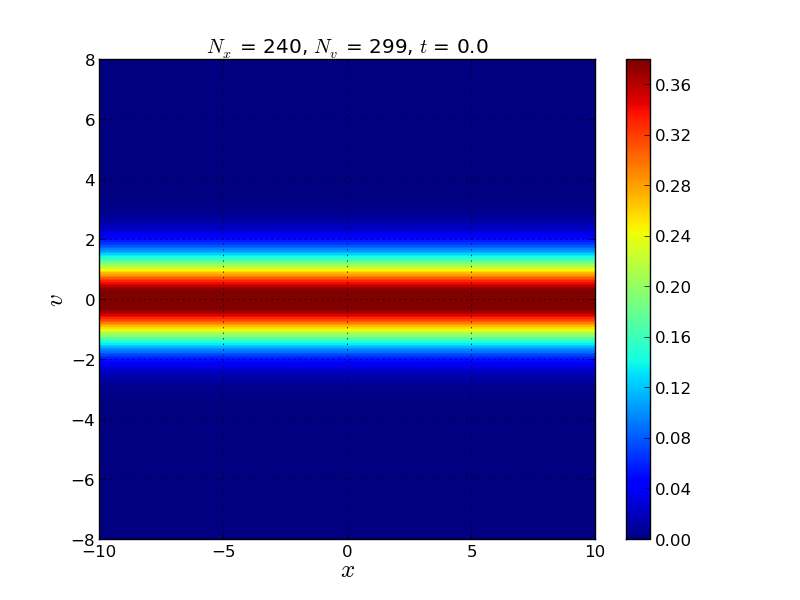

In [1]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_electron_LF2_Nx240Nv300Nt2000_it00000.png')

Electrons accelerate towards the right wall towards the positive potential. Note that electrons start with both positive (right moving) and negative (left moving) velocities. On the left, there is some response where the electrons are drawn to the large and slow populations of ions that build up near the left edge, hence transiently increasing their speeds to be more negative (e.g. those electrons that began at time zero with negative velocities get more largely negative due to the nearby ions. This happens slower than if the right wall were to not be there, but since the wall is further off, its effect on influencing electrons to all move right is not the whole story). Those electrons with positive velocity flow towards the wall and are absorbed. Those with small speeds of either sign can drift towards the right if close enough or tend towards the left.

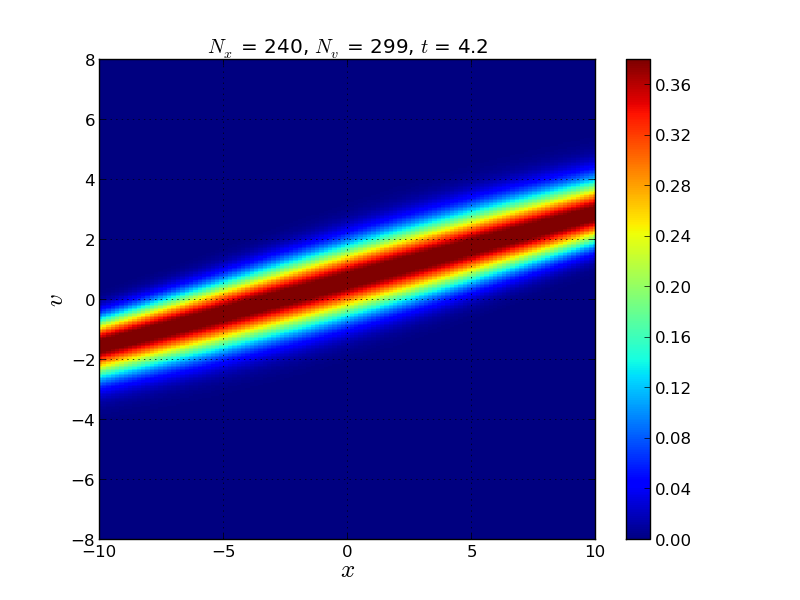

In [2]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_electron_LF2_Nx240Nv300Nt2000_it00096.png')

The distribution begins to noticeably deplete.

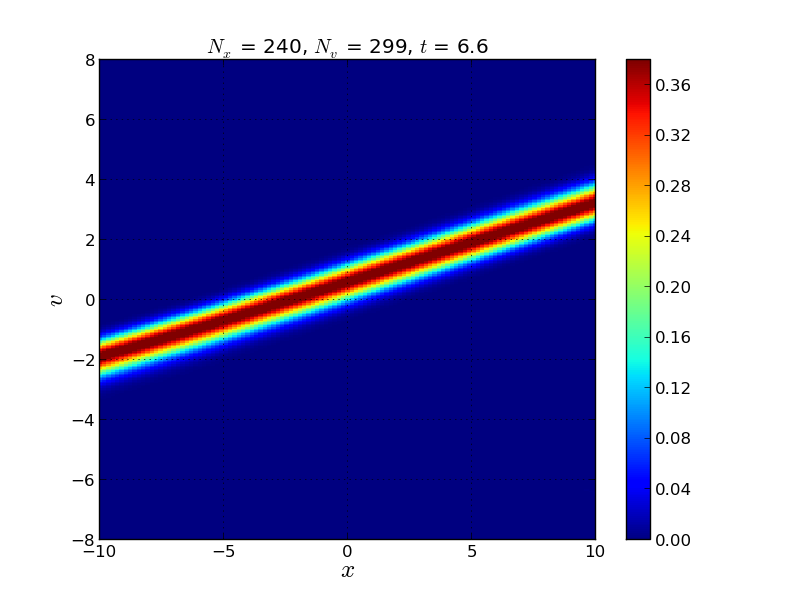

In [3]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_electron_LF2_Nx240Nv300Nt2000_it00151.png')

Too many electrons have reached the left wall to continue the initial attractive pull from the ion populations on the left. The repulsion from the high density of electrons as  well as the negative wall potential eventually leads (as shown) the total distribution of electrons to acquire totally positive (rightward velocity) as the population continues to diminish and head rightward to the positively biased wall.

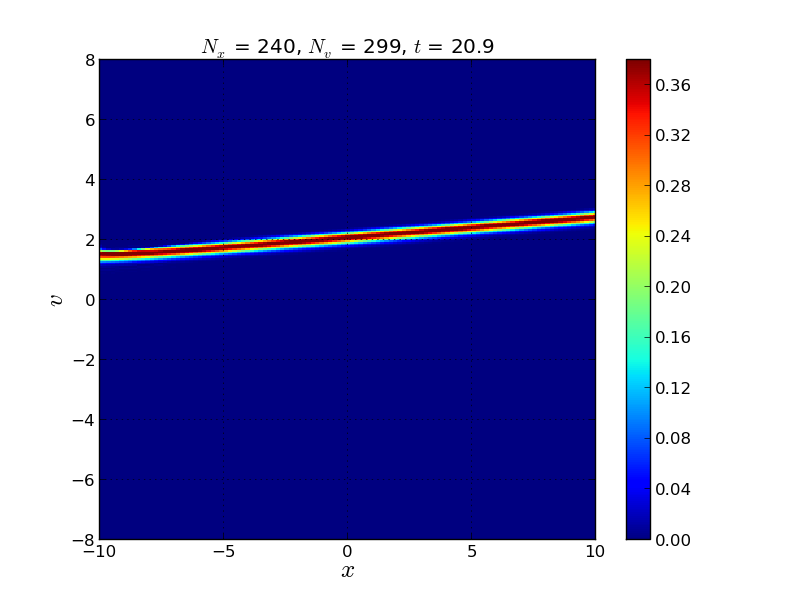

In [4]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_electron_LF2_Nx240Nv300Nt2000_it00475.png')

With their rightward velocity, electrons travel from left to right. Here, enough have been absorbed to where we see the distribution retreating, and see spatial depletion of electron populations near the negatively biased (left) wall as expected.

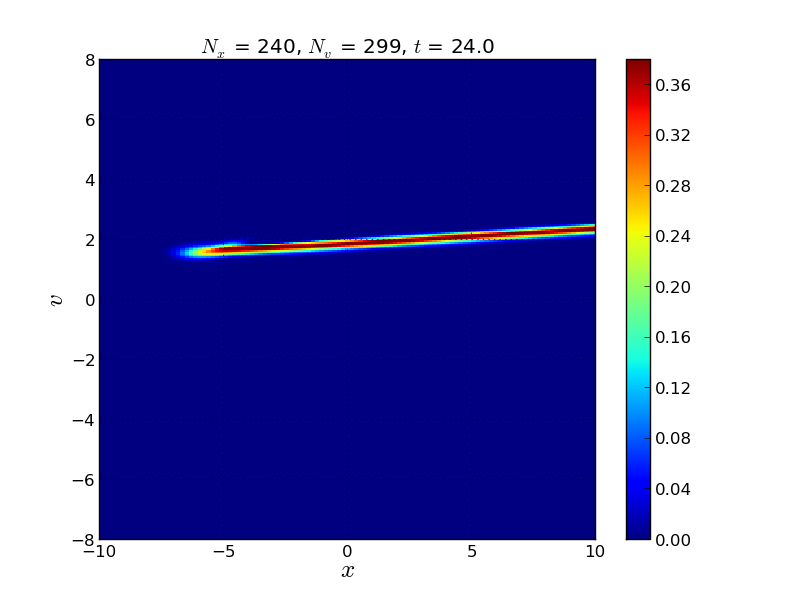

In [5]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_electron_LF2_Nx240Nv300Nt2000_it00546.png')

After, the above plot the electron density continues to move rightward, but does so too quickly so that too many electrons arrive at the right-edge. The large electron populations in the vicinity of the right edge decreases the speed of right moving electrons due to electrostatic interactions of the same charge species, eventually dipping it negative so that they get pushed back and head left. When the electrons become sufficiently rareified by this action, they turn around and head back towards the right, where they are all absorbed before the end of the simulation.

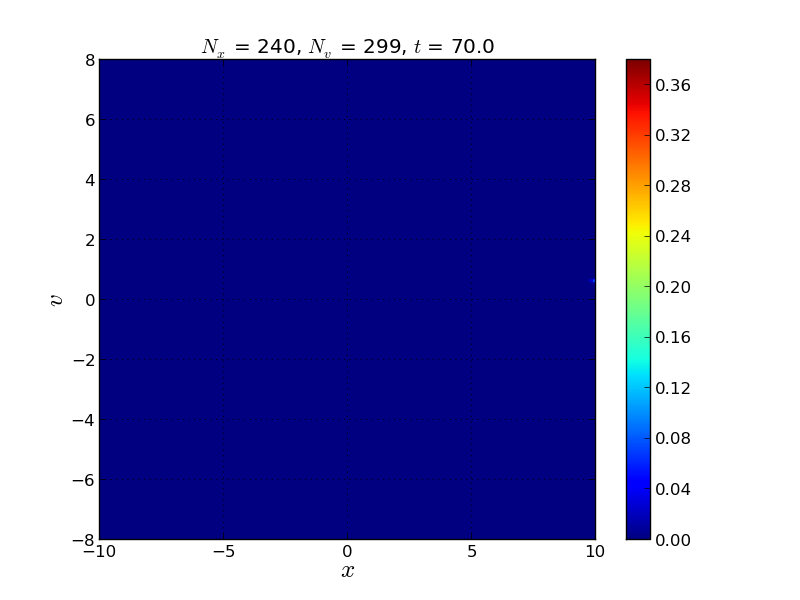

In [6]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_electron_LF2_Nx240Nv300Nt2000_it01591.png')

### ions at various times (see titles for times)

Nonzero, but uniform everywhere.

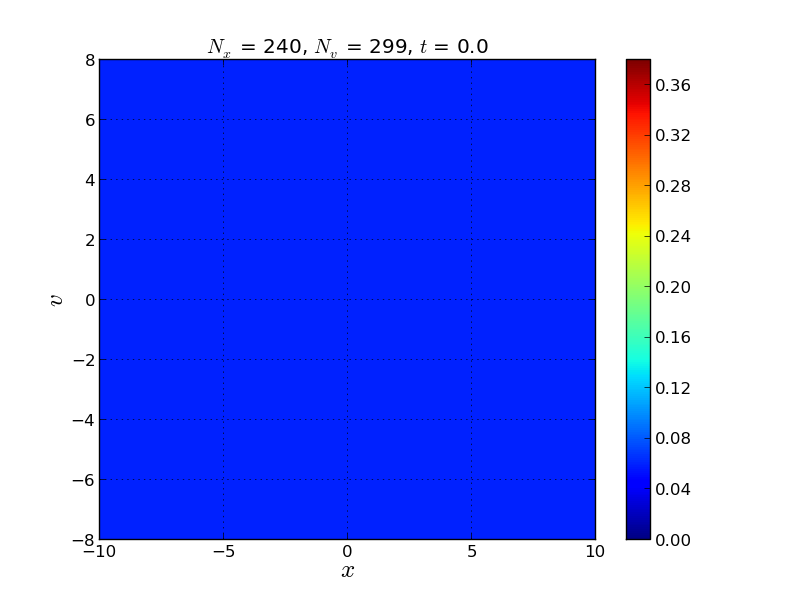

In [7]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_ion_LF2_Nx240Nv300Nt2000_it00000.png')

The outgoing fluxes at the walls get absorbed. Independent of the electrons, the ions would rush towards the left-wall (biased negative). The ions in the top left corner of phase space with the greatest right-moving (positive) velocity are hence deccelerated which depletes this region of phase space. Conversely, on the bottom-right portion of phase space the ions with the most largely left-moving (negative) velocites are deccelerated by the large number of electrons that have rushed towards the this right-wall (as well as due to the repulsive potential at this wall). Those with the greatest speeds are both absorbed whereas others with the same velocity may be influenced by nearby electrons in the opposite direction of the wall, lowering their magnitude and so on (there are many circumstances we can envisage).

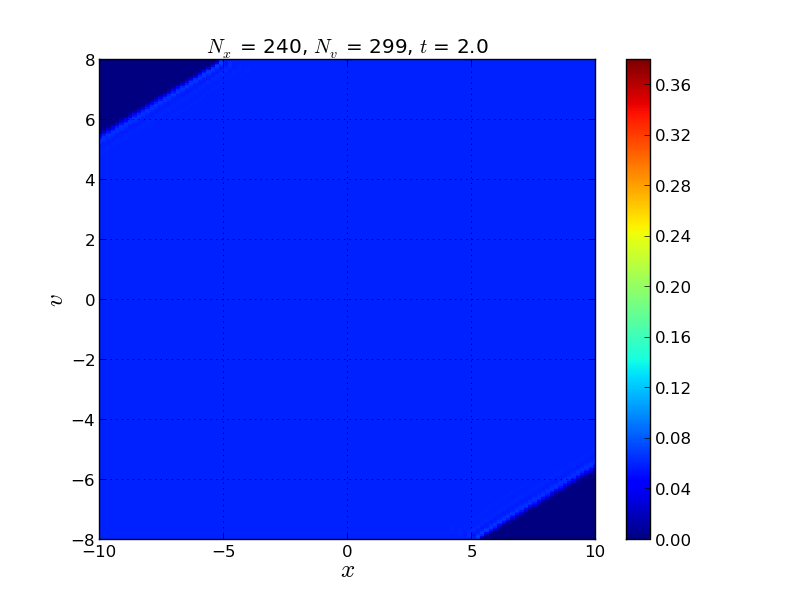

In [8]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_ion_LF2_Nx240Nv300Nt2000_it00045.png')

The trend continues, where we see depletion of the ion density. This happens slower than the electrons given the differences in inertia.

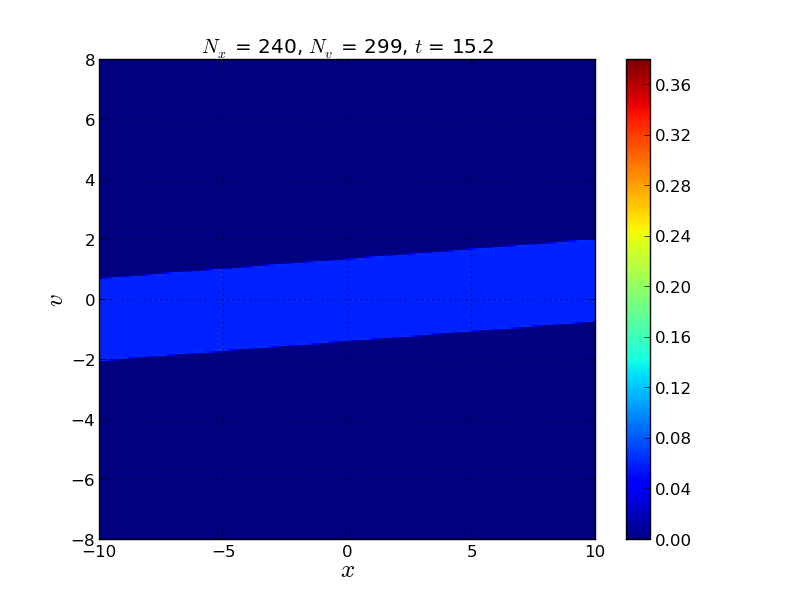

In [9]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_ion_LF2_Nx240Nv300Nt2000_it00346.png')

The trend continues. By the simulation end time the ion density dwindles.

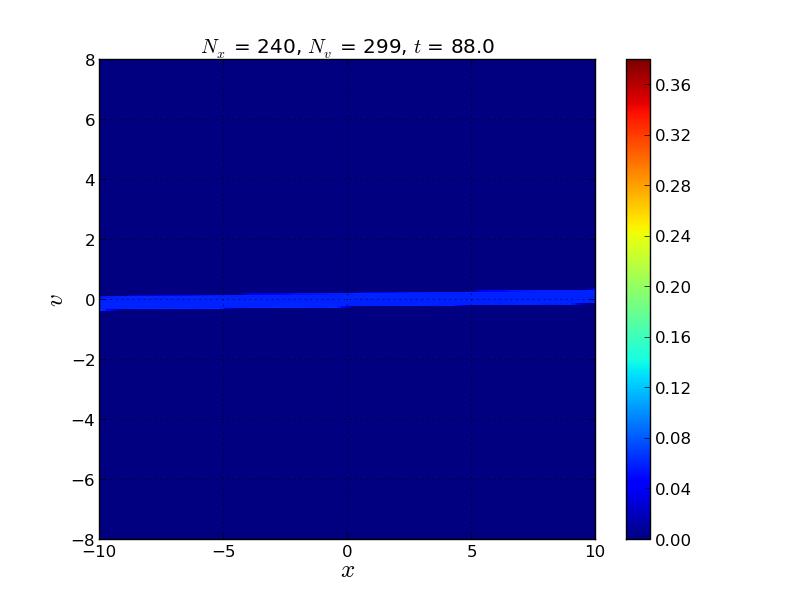

In [10]:
from IPython.display import Image
Image(filename='./fig/s18-02/plot_-_1D1V_ion_LF2_Nx240Nv300Nt2000_it02000.png')

# Objective 3: self-consistent calculation of potentials on walls

We move onto including functionality permitting boundary conditions on the potential to be calculated as (see ) on a wall at a location $x = x_w$ as:

$$\partial_x\phi (t, x_w) = -\frac{1}{2}\sigma (t, x_w), \qquad \text{self-consistent boundary condition}$$

Suppose $x = x_w$ is a "left" wall, hence we require adding up the charge from all left-going fluxes (negative velocities) that reach the wall at $x = x_w$. Thus, the surface charge density (recall our normalized units have $q_e = -1$, $q_i = +1$) would be:

$$\sigma (t, x = \pm L) = \int_0^t dt' \int_{-\infty}^0 dv_x v_x\left(f_i(t', x_w) - f_e(t', x_{w})\right)$$

the charge density $\sigma$ can be stored in an object <code>sigma</code> where <code>sigma.shape = (t.N+1,)</code>, recall that <code>t.N</code> is the total number of steps, we write the above to include time zero.

A natural discretization of the above is:

$$\sigma (t^k, x_w) = \sum_{v_j\colon v_j < 0 } \Delta v \, v_j ( f_i(t^k, x_w) - f_e(t^k, x_w)$$

$$\sigma (t^n, x_w) = \sum_{k = 0}^n \Delta t \, \sigma (t^k, x_w), \qquad \text{where } t^n \geq t^k$$



We can create the affect of a charged wall by using the means used in the absorbing conditions. We check which in <code>z.postpointmesh</code> correspond to indices at the left wall or beyond at this time step. All such densities at <code>f_old[ z.postpointmesh, vz.prepointmesh ]</code> are computed in the above sum along with their corresponding velocities at each vz.prepointmesh where z.postpiontmesh is at the left boundary or beyond. This can be done with masks for example.